In [190]:
import os
import json
import numpy as np


def get_data(file_dir):
    """
    Will read JSON files from the provided file directory and subdirectories and return a list of dicts
    :param file_dir: directory where to look for input JSON files
    """
#     print('Starting to read JAAD json files!')
    json_list = []

    for dirpath, dirnames, filenames in os.walk(file_dir):
        JAAD_list = [pos_json for pos_json in filenames if pos_json.endswith('.json')]
        for js in JAAD_list:
            with open(os.path.join(dirpath, js)) as json_file:
                json_list.append(json.load(json_file))

    return json_list

In [191]:
#lst_new:all the filename
def file(folder_path):
    with open(folder_path) as file:
        lst=[]
        for eachline in file:
            eachline=eachline.rstrip('\n')
            lst.append(eachline)
        lst_new=lst[1:-1]
    return lst_new       

In [192]:
json_list1=get_data('JAAD_output_JSON/video_0001')
json_list2=get_data('JAAD_output_JSON/video_0002')

In [41]:
def get_index(filename):
    name=file(filename)
    index=[]
    for i in name:
        index.append(int(i[-4:]))
    return index

In [193]:
# index of the videos
index=get_index('JAAD_output_JSON/LIST.TXT')

In [194]:
#create a dictionary which could save variables from json_list1 to json_list346
def define_Dict(filename):
    D={}
    lst=file(filename)
    index=get_index(filename)
    for num,i in enumerate(lst):
        json_list_name = f"json_list{index[num]}"
        D[json_list_name]=get_data(f'JAAD_output_JSON/{lst[num]}')
    return D

In [195]:
Dict=define_Dict('JAAD_output_JSON/LIST.TXT')

In [203]:
#input:file content
# return:(25,2)data
#in this function the coordinate data would be extracted
def transform_to_arr(lst):
    lst_x=[]
    lst_y=[]
    for num,i in enumerate(lst):
        if num%3==0:
            lst_x.append(i)
        if num%3==1:
            lst_y.append(i)
    data=np.stack((np.array(lst_x),np.array(lst_y)),axis=-1)
    return data

In [204]:
data0=transform_to_arr(json_list1[0]['people'][0]['pose_keypoints_2d'])

In [205]:
# def stacked_data(lst):
#     arr=np.empty((0,2))
#     data=[]
#     for i in range(len(lst)):
#         if 'people' in lst[i]:
#             for j in range(len(lst[i]['people'])):
#                 arr=transform_to_arr(lst[i]['people'][j]['pose_keypoints_2d'])
#                 print(j)
#                 data.append(arr)
#         elif 'pose_keypoints_2d' in lst[i]:
#             arr=transform_to_arr(lst[i]['pose_keypoints_2d'])
#             data.append(arr)
#     stacked_data=np.stack(data,axis=0)
#     return stacked_data

In [206]:
#only extract the first person's infomation
def stacked_data(lst):
    arr=np.empty((0,2))
    data=[]
    for i in range(len(lst)):
        if 'people' in lst[i] and lst[i]['people']!=[]:
            arr=transform_to_arr(lst[i]['people'][0]['pose_keypoints_2d'])
            data.append(arr)
        elif 'pose_keypoints_2d' in lst[i]:
            arr=transform_to_arr(lst[i]['pose_keypoints_2d'])
            data.append(arr)
    stacked_data=np.stack(data,axis=0)
    return stacked_data

In [208]:
import matplotlib.pyplot as plt

def plot_skeleton2D(skeleton, connect_points=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = skeleton[:, 0]
    y = skeleton[:, 1]
    ax.scatter(x, y, c='b', marker='o')
    if connect_points:
        for points in connect_points:
            x_points = x[points]
            y_points = y[points]
            ax.plot(x_points, y_points, c='r')
    for i,(xi,yi) in enumerate(zip(x,y)):
        ax.annotate(str(i),(xi,yi), textcoords="offset points", xytext=(0,10), ha='center')
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()
connect_points=[[0,1],[0,15],[0,16],[1,2],[1,5],[1,8],[5,6],[6,7],[2,3],[3,4],[12,13],[13,14],[9,10],[10,11],[8,9],[8,12],[14,21],[11,24],[14,20],[20,19],[11,22],[22,23]]

In [209]:
#find outliers
#data:stacked data e.g(623,25,2)
def make_zero_to_mean(data):
    data_new=data
    for i in range(data.shape[0]):
        if np.any(np.all(data[i]==[0,0],axis=1)):
            outliers=np.where((data[i][:,0]==0)&(data[i][:,1]==0))
            #calculate the mean without outliers
            lst=list(outliers[0])
            for j in lst:
                data_new=np.delete(data[i],int(j),axis=0)
            new_points_mean=np.mean(data_new,axis=0)
            #replace outliers[0,0] with new__mean
            data[i][outliers] = new_points_mean
        else:
            data[i]=data1[i]
    return data

In [210]:
#Min-Max-Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
def MinMaxScaling(data):
    data_new=make_zero_to_mean(data)
    for i in range(data_new.shape[0]):
        data_new[i]=scaler.fit_transform(data_new[i])
    return data_new

In [211]:
def get_x_data_inGeneral(D):
    lst=[]
    for i in index:
        data=stacked_data(D[f'json_list{i}'])
        data_preprocessing=MinMaxScaling(data)
        lst.append(data_preprocessing)
    return lst

In [212]:
stacked_data(Dict['json_list54']).shape

(321, 25, 2)

In [213]:
# lst constains all of the 145 videos,each shape is (N,25,2)
lst=get_x_data_inGeneral(Dict)
len(lst)

145

In [214]:
#find index
index.index(2)

1

In [215]:
#length of a series
lst[0].shape

(563, 25, 2)

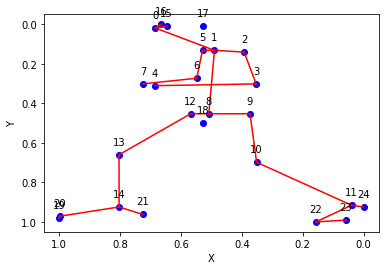

In [216]:
#video243:run
plot_skeleton2D(lst[100][51],connect_points)

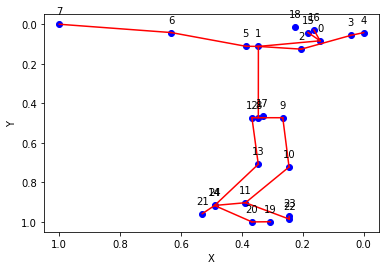

In [217]:
#video294:standing
plot_skeleton2D(lst[126][78],connect_points)

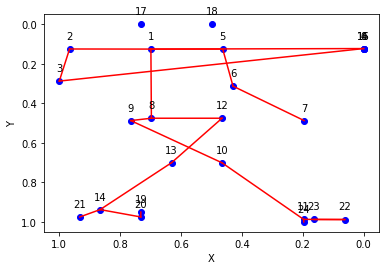

In [218]:
#video2:walking
plot_skeleton2D(lst[1][140],connect_points)

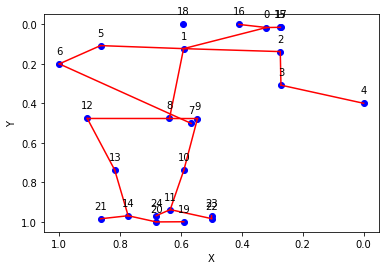

In [219]:
#video1:looking at Vehicles and show hands
plot_skeleton2D(lst[0][350],connect_points)

## Semi-supervised learning,make some labels manuelly firstly

In [170]:
#stack all data together
X=np.empty((1,25,2))
for i in lst:
    X=np.concatenate((X,i),axis=0)

In [173]:
#make labels,initial:all equal for -1
Y=-1*np.ones((23408))

In [220]:
#input is the index of videos:for example:3 is video_0003
#return:where this video data begin in the whole dataset
def find_current_index(ind):
    num=index.index(ind)
    summ=0
    for i in range(num):
        summ+=lst[i].shape[0]
    return summ

In [221]:
find_current_index(346),lst[-1].shape

(23342, (65, 25, 2))

In [222]:
#standing:0
#walking:1
#running:2
#holding phone:3
#looking at AV:4
#showing hands to AV:5

In [223]:
#make some labels manuelly
#video0:
Y[0:146]=0
Y[156:337]=0
Y[400:528]=1
Y[147:149]=5
#video2:
Y[find_current_index(2)+5]=0
Y[find_current_index(2)+17:find_current_index(2)+19]=0
Y[find_current_index(2)+20:find_current_index(2)+177]=1
#video3:
Y[find_current_index(3):find_current_index(4)]=1
#video9:
Y[find_current_index(9)+30:find_current_index(9)+37]=0
Y[find_current_index(9):find_current_index(9)+18]=1
Y[find_current_index(9)+43:find_current_index(9)+75]=1
#video10:
Y[find_current_index(10)+15:find_current_index(10)+19]=1
#video11:
Y[find_current_index(11)+15:find_current_index(11)+19]=0
Y[find_current_index(11)+51:find_current_index(11)+94]=1
#video12:
Y[find_current_index(12)]=1
#video14/17/21:
Y[find_current_index(14):find_current_index(23)]
#video42:
Y[find_current_index(42):find_current_index(44)]=1
#video90:
Y[find_current_index(90):find_current_index(90)+48]=0
Y[find_current_index(90)+48:find_current_index(90)+208]=1
#video102:
Y[find_current_index(102)+76:find_current_index(102)+249]=3
#video107:
Y[find_current_index(107)+7:find_current_index(107)+42]=0
Y[find_current_index(107)+43:find_current_index(107)+139]=1
#video123:
Y[find_current_index(123)+27:find_current_index(123)+116]=2
Y[find_current_index(123):find_current_index(123)+4]=4
#video140:
Y[find_current_index(140):find_current_index(140)+33]=0
Y[find_current_index(140)+33:find_current_index(140)+166]=1
#video158:
Y[find_current_index(158):find_current_index(158)+16]=0
Y[find_current_index(158)+38:find_current_index(158)+163]=1
#video243:
Y[find_current_index(243)+20:find_current_index(158)+91]=2
#video294:
Y[find_current_index(294)+29:find_current_index(294)+76]=0
Y[find_current_index(294)+80:find_current_index(294)+142]=1
#video295:
Y[find_current_index(295)+121]=3
Y[find_current_index(295)+219:find_current_index(295)+281]=3
#video304:
Y[find_current_index(304)+63:find_current_index(304)+91]=0
#video308:
Y[find_current_index(308):find_current_index(312)]=1
#video315
Y[find_current_index(315)+101:find_current_index(315)+184]=1
Y[find_current_index(315)+3]=4
Y[find_current_index(315)+7]=4
#video318
Y[find_current_index(318):find_current_index(318)+235]=1
#video329
Y[find_current_index(329):find_current_index(329)+91]=1
Y[find_current_index(329)+91:find_current_index(329)+131]=4
#video339
Y[find_current_index(339)+8:find_current_index(339)+21]=0
Y[find_current_index(339)+127:find_current_index(339)+177]=1

In [224]:
find_current_index(14),find_current_index(23)

(1406, 1971)

In [225]:
lst[10].shape,lst[11].shape,lst[12].shape

((149, 25, 2), (268, 25, 2), (148, 25, 2))

### Semi-Supervised learning

In [180]:
#SK-Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [181]:
# Label Spreading
label_prop_model = LabelSpreading()

In [182]:
X_new=X.reshape(23408,50)
X_new_=X_new[:5000]
Y=np.array(Y,dtype=int)
Y_new_=Y[:5000]

In [184]:
#fit to Label Spreading 
label_prop_model.fit(X_new_,Y_new_)

# Predict the Labels for Unlabeled Samples
pred_lb = label_prop_model.predict(X_new_)

In [185]:
# Feature& Target  Dataset
X_ = X_new_
y_ = Y_new_  # labels predicted by Label Spreading

#Dataset Split  [train = 90%, test = 10%]
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.1, random_state=0) 

#Define Model
model = RandomForestClassifier(verbose = 0, max_depth=2, random_state=0)

#Fit
model.fit(X_train,y_train)

#Prediction
rf_pred = model.predict(X_test)
#Accuracy Score
acc = accuracy_score(y_test, rf_pred)
print("Random Forest Model Accuracy (after Label Spreading): ",'{:.2%}'.format(acc))

Random Forest Model Accuracy (after Label Spreading):  76.60%


In [188]:
pred_lb[:500],Y_new_[:500]

(array([1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 1, 0, 0, 0, 0,
        5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [72]:
index[63]

140

In [ ]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [281]:
kmeans=KMeans(n_clusters=4)
kmeans.fit(X_new)
cluster_labels = kmeans.labels_
pseudo_labels=cluster_labels

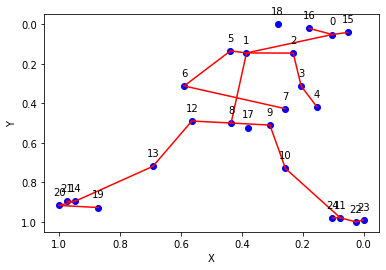

In [284]:
plot_skeleton2D(X[600],connect_points)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=10)#10 features
rf_classifier.fit(X_new,pseudo_labels)
features = rf_classifier.predict_proba(X_new)

In [ ]:
features.shape

In [ ]:
X.shape

In [ ]:
X_tr=X[:20000]
pseudo_labels_tr=pseudo_labels[:20000]
X_te=X[20000:]
pseudo_labels_te=pseudo_labels[20000:]

### LSTM Model

In [ ]:
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense,Input

# # define model
# timesteps,features,coordinate_values=X_tr.shape
# model = Sequential()
# # model.add(LSTM(units=32, input_shape=(timesteps, features))) 
# model.add(LSTM(64,input_shape=(features, coordinate_values)))
# model.add(Dense(1))  # output layer，units is the unit number for output

# # compile model
# model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# # train model
# model.fit(X_tr, pseudo_labels_tr, epochs=10, batch_size=32) 

# # prediction
# predictions = model.predict(X_te)

# round_pred=np.round(predictions).astype(int)

# round_pred[-20:]

# pseudo_labels_te[-20:]